## Generate EDA Report

In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')

## Loading Datasets into Pandas DataFrame

In [2]:
auto_df = pd.read_csv('../data/autoscout24-germany-dataset.csv')

## Generate EDA Report

In [18]:
profile = ProfileReport(auto_df, title='Exploratory Data Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Preprocess Based on EDA Report

- Missing Values Analysis
- Outlier Analysis

Duplicated Rows are not being removed due to exact same type of vehicles can be purchased on the same year with same specs

Missing Value is detected in 3 columns: ['model', 'gear', 'hp']
KNN Imputation with n_neighbor of 5 is used for missing values treatment, after the treatment, no more missing values in our datasets.

In [3]:
print('Data Missingness')
print(auto_df.isnull().sum())
missing_value_analysis = utils.Missing_Value_Analysis(auto_df)
df_impute = missing_value_analysis.KNN_imputer(n=5)
print('\nAfter Missing Value Imputation')
print(df_impute.isnull().sum())

Data Missingness
mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64

After Missing Value Imputation
mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
year         0
dtype: int64


Outlier Analysis is done based on grid search of the Z score threshold to find the extreme values. In this case, the outlier rows are being removed from our datasets to prevent misinformation and reduce error in our analysis.

Note: Only numerical columns (except 'year') are being selected for the outlier analysis. ['mileage', 'price', 'hp']

No outlier for hp


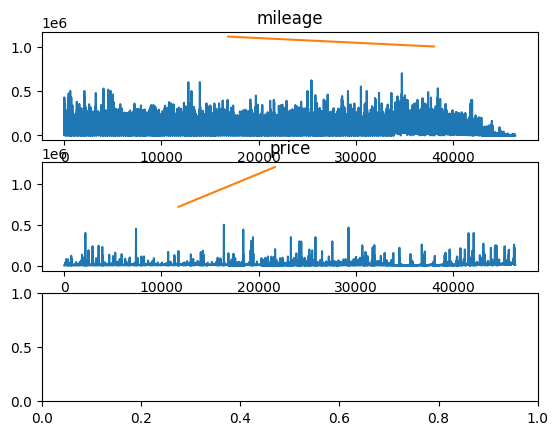

In [4]:
outlier_analysis = utils.Outlier_Analysis(df_impute)
df_final = outlier_analysis.outlier_gridsearch(['mileage', 'price', 'hp'])

## Feature Engineering

Creating new feature to identify the vehicles purchased are Internal Combustion Engine(ICE) or Electric Vehicles(EV). In the engine column, we classify ['Electric','Electric/Gasoline', 'Electric/Diesel'] as electric vehicles, all other values as ICE vehicles.

In [5]:
electric = ['Electric','Electric/Gasoline', 'Electric/Diesel']
df_final['engine'] = 'ICE'
df_final.loc[df_final['fuel'].isin(electric), 'engine'] = 'EV'
df_ev = df_final.loc[df_final['engine']=='EV',['year', 'fuel']]
df_ice = df_final.loc[df_final['engine']=='ICE',['year', 'fuel']]

## Trend Analysis

Seasonal data decomposition based on yearly data to find out the trend of EV and ICE purchase over the past 10 years

<AxesSubplot: title={'center': 'Trend for Electric Vehicles'}, xlabel='year'>

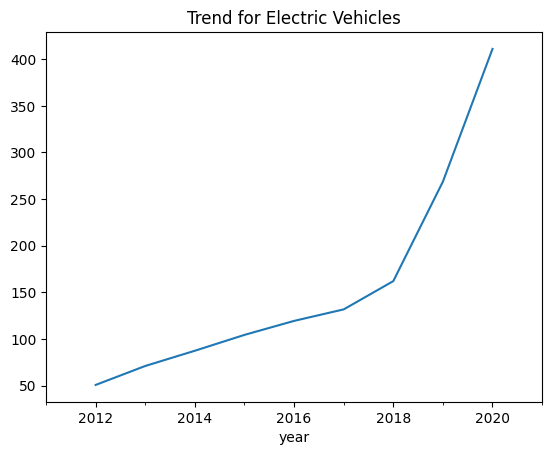

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_ev.set_index('year',inplace=True)
df_ev.index = pd.to_datetime(df_ev.index,format='%Y')
result = seasonal_decompose(df_ev.groupby(['year']).size(), period = 3)
result.trend.plot(title='Trend for Electric Vehicles')

<AxesSubplot: title={'center': 'Trend for Internal Combuston Engine'}, xlabel='year'>

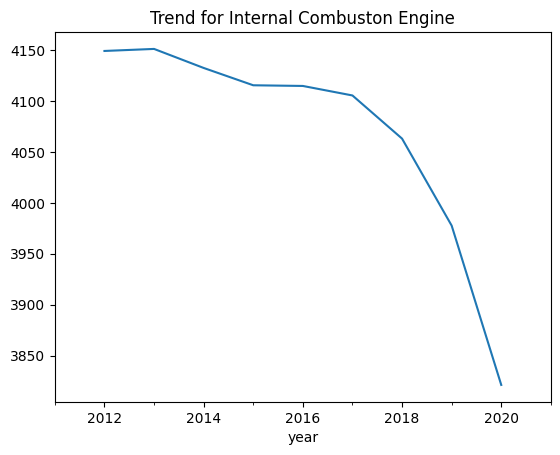

In [7]:
df_ice.set_index('year',inplace=True)
df_ice.index = pd.to_datetime(df_ice.index, format='%Y')
result = seasonal_decompose(df_ice.groupby(['year']).size(), period = 3)
result.trend.plot(title='Trend for Internal Combuston Engine')

From the trend analysis, we can see the past 10 years of EV purchase is trending upwards while ICE purchase is having declining sales. However, it is noteworthy to realize the **total amount of purchase** is still having a large gap between EV and ICE, consumers generally are still getting used to purchase ICE even though the trend is growing for EV.

## Consumer Purchase Preference (New Car vs Used Car)

engine
EV      1
ICE    12
dtype: int64

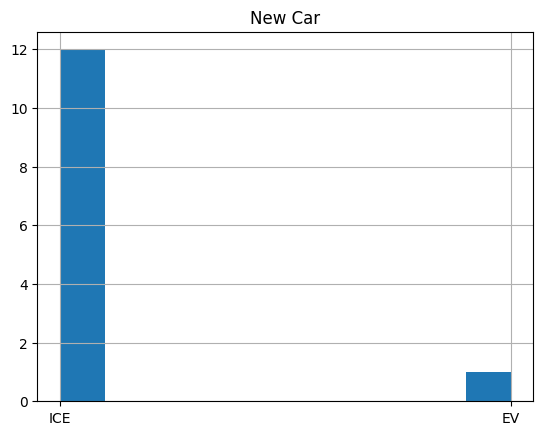

In [8]:
df_final[df_final['offerType']=='New']['engine'].hist()
plt.title('New Car')
df_final[df_final['offerType']=='New'].groupby(['engine']).size()

engine
EV      1161
ICE    38957
dtype: int64

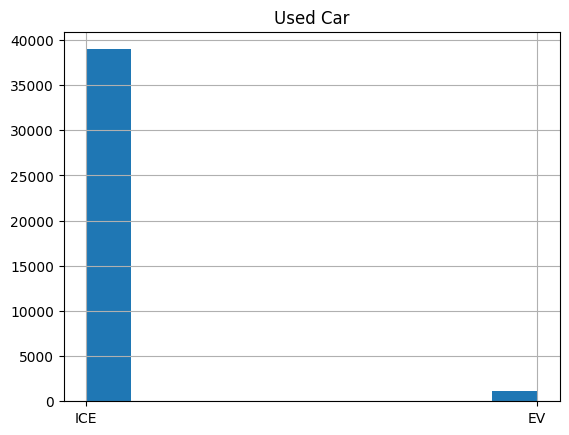

In [9]:
df_final[df_final['offerType']=='Used']['engine'].hist()
plt.title('Used Car')
df_final[df_final['offerType']=='Used'].groupby(['engine']).size()

In this comparison, we can see that consumer prefer to purchase used EV (1161) compared to new EV (1). The histogram also shows that the EV sales is still having a big gap even though is catching up with the trend we analysed previously. 

## Time Series Analysis

Wr fit the past 9 years of sales EV sales data into ARIMA data to train and do prediction to evaluate on test data which is the latest 2 years (2020 and 2021). ADF test positive shows that the data is stationery and able to proceed for ARIMA model fit.

In [10]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
df_ev_ts = pd.DataFrame(df_ev.groupby(['year']).size(), columns=['purchase'])
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_ev_ts)

(0.783046140824871, True)

In [11]:
train = df_ev_ts[df_ev_ts.index < '2020-01-01']
test = df_ev_ts[df_ev_ts.index >= '2020-01-01']
arima_model = auto_arima(train, start_p=1, d=0, start_q=0,
                        max_p=5, max_q=5, start_P=0,
                        D=1, start_Q=0, max_P=5, max_D=5,
                        max_Q=5, m=12, seasonal=False,
                        trace=True, stepwise=True,
                        randome_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=94.762, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=113.393, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=95.615, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=95.430, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.329 seconds


In [12]:
prediction = pd.DataFrame(arima_model.predict(n_periods=5))
prediction

,0
2020-01-01,210.023860
2021-01-01,205.162892
2022-01-01,200.414430
2023-01-01,195.775871
2024-01-01,191.244670


## Bad ARIMA results

From the prediction we can see that ARIMA perform badly in predicting the future EV sales.

## ETS model

We can use Exponential Smoothing algorithm in order to fit all data into training and fit ETS model for prediction. The simplest of the ETS models is also known as simple exponential smoothing. Here, the forecast/expectation given the information of the previous step. In the simple exponential smoothing model, the forecast corresponds to the previous level. The smoothing equation calculates the next level as weighted average of the previous level and the previous observation.

Mean Absolute Percentage Error: 13.08%


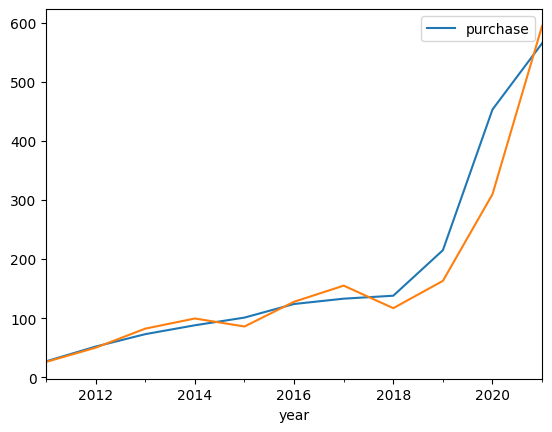

In [13]:
ETS_EV = utils.ETS_Model(df_ev_ts, 'purchase')
ETS_EV.fit_model()
ETS_EV.evaluate_model()

In [14]:
ETS_EV.predict(5)

2022-01-01     750.402851
2023-01-01     989.176494
2024-01-01    1032.302105
2025-01-01    1225.104807
2026-01-01    1493.838111
Freq: AS-JAN, Name: simulation, dtype: float64


Mean Absolute Percentage Error: 1.22%


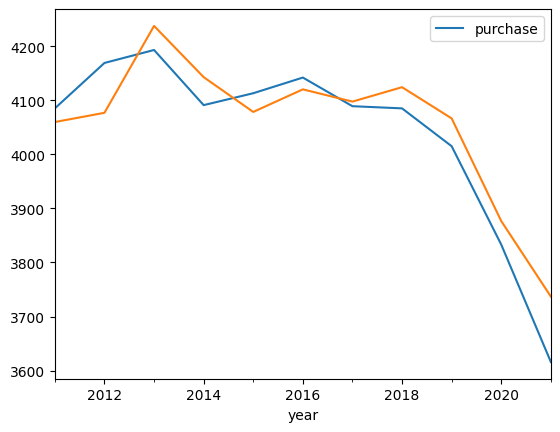

In [15]:
df_ice_ts = pd.DataFrame(df_ice.groupby(['year']).size(), columns=['purchase'])
ETS_ICE = utils.ETS_Model(df_ice_ts, 'purchase')
ETS_ICE.fit_model()
ETS_ICE.evaluate_model()

In [16]:
ETS_ICE.predict(5)

2022-01-01    3387.672379
2023-01-01    3106.338777
2024-01-01    2897.904611
2025-01-01    2680.612375
2026-01-01    2422.418232
Freq: AS-JAN, Name: simulation, dtype: float64


The ETS model able to get low mean absolute percentage error (MAPE) in both EV and ICE data and we are able to use the model to predict next 5 years sales of EV and ICE vehicles. When more data comes in we can automate to evaluate the model on yearly basis and monitor data or model drift in order to retrain the model to keep up with the real world trend.

## Best Type of EV and ICE

In the past 10 years, the best type of ICE are gasoline car made by Hyundai while the best type of EV is Electric/Gasoline car made by Fiat. The future will be more positive for EV as more car makers are into EV markets and wider EV charger networks available for consumers.

At the same time, in October 2022 EU Commission had agreed on a deal to end the sale of CO2 emitting vehicles by the end of 2035 in Europe. This policy will accelerate the trend we predicted for EV to grow faster and ICE to decline steeper.

In [17]:
df_final.drop(columns=['year'], inplace=True)
df_final.groupby(df_final.columns.tolist(),as_index=False).size().sort_values('size', ascending=False)

,mileage,make,model,fuel,gear,offerType,price,hp,engine,size
1665,15,Hyundai,i10,Gasoline,Manual,Pre-registered,9990,25,ICE,19
115,2,Dacia,Duster,Gasoline,Manual,Pre-registered,16840,42,ICE,17
1416,10,Toyota,Aygo,Gasoline,Manual,Pre-registered,11990,29,ICE,17
2639,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,14490,28,EV,17
2635,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,28,EV,13
...,...,...,...,...,...,...,...,...,...,...
15200,36062,Ford,Focus,Diesel,Automatic,Used,13370,64,ICE,1
15201,36076,Volkswagen,Polo,Gasoline,Automatic,Used,12450,42,ICE,1
15202,36077,Alpina,B3,Gasoline,Automatic,Used,64890,243,ICE,1
15203,36085,Volkswagen,up!,Gasoline,Manual,Used,7450,20,ICE,1
